## Synthetic Full Tensor Gravity Gradiometry : Ensemble

This notebook is the introduction to `tensorweave`. Using a simple synthetic dataset generated in SimPEG (Cockett et al, 2015), this notebook demonstrates the power of interpolating tensor fields using the underlying potentials.

### Setup & Imports
Import required Python packages and your project modules. These imports do not change any state beyond making functionality available.

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import tensorweave as tw

# Set device
device = "cpu"
dtype = torch.float32

In [2]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../additional_utils/Fonts/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-5, 5]

# OPTIONAL CUSTOM COLORMAP
import matplotlib.colors as mcolors

# Define the colors extracted manually from the curlew
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)
curlew_cont = mcolors.LinearSegmentedColormap.from_list(name="curlew_cont", colors=colors)

### High resolution Ground Truth

Read the high resolution data and use the grid to define the points at which the low resolution grid will be interpolated.

In [3]:
# High resolution dataset
full_dataset_hr = np.load("../Datasets/synthetic_highres.npy")
# Coordinates (m)
xyz_hr = full_dataset_hr[:, (0, 1, 2)]
# Gravitational acceleration (mGal)
g_hr = full_dataset_hr[:, (3, 4, 5)]
# Gradiometry (Eotvos)
ftg_hr = full_dataset_hr[:, 6:]

# Interpolation grid from the high res dataset
xvec = xyz_hr[:, 0] # Extract x-coordinates
yvec = xyz_hr[:, 1] # Extract y-coordinates
zvec = xyz_hr[:, 2] # Extract z-coordinates
grid = np.c_[xvec, yvec, zvec] # shape: (N, 3)
actv = np.ones_like(xvec).astype(bool) # Active grid points (all points are active in this case)
shape = (65, 65) # Reshape for plotting
x_mesh = xvec.reshape(shape)[:, 0] # Reshape x-coordinates for plotting
y_mesh = yvec.reshape(shape)[0] # Reshape y-coordinates for plotting

### Low Resolution Flight Lines

We use flight lines with high inline sampling and low crossline sampling (200 m) to mimic acquisition conditions.

In [4]:
# Low resolution dataset
full_dataset = np.load("../Datasets/synthetic_lowres_200.npy")
# Coordinates
xyz = full_dataset[:, (0, 1, 2)]
# Gravitational acceleration
g = full_dataset[:, (3, 4, 5)]
# Gradiometry
ftg = full_dataset[:, 6:]
# Add some noise to the data
ftg = tw.add_ftg_noise_by_snr(ftg, snr_db=[20, 18, 18, 15, 17, 19])
ftg[:, -1] = -(ftg[:, 0] + ftg[:, 3])  # Enforce tracelessness

# Also load the density model and plot a cross-section for visualization!
syn_model = np.load("../Datasets/synthetic_model.npy")
# Extract a Model Slice
model_slice_idx = syn_model[:, 2] == -140
plot_model = syn_model[model_slice_idx]
# For plotting
model_x = np.linspace(np.nanmin(syn_model[:, 0]), np.nanmax(syn_model[:, 0]), 120)
model_y = np.linspace(np.nanmin(syn_model[:, 1]), np.nanmax(syn_model[:, 1]), 120)

### Visualise the model and data!

Plot the model and the corresponding low and high resolution datasets.

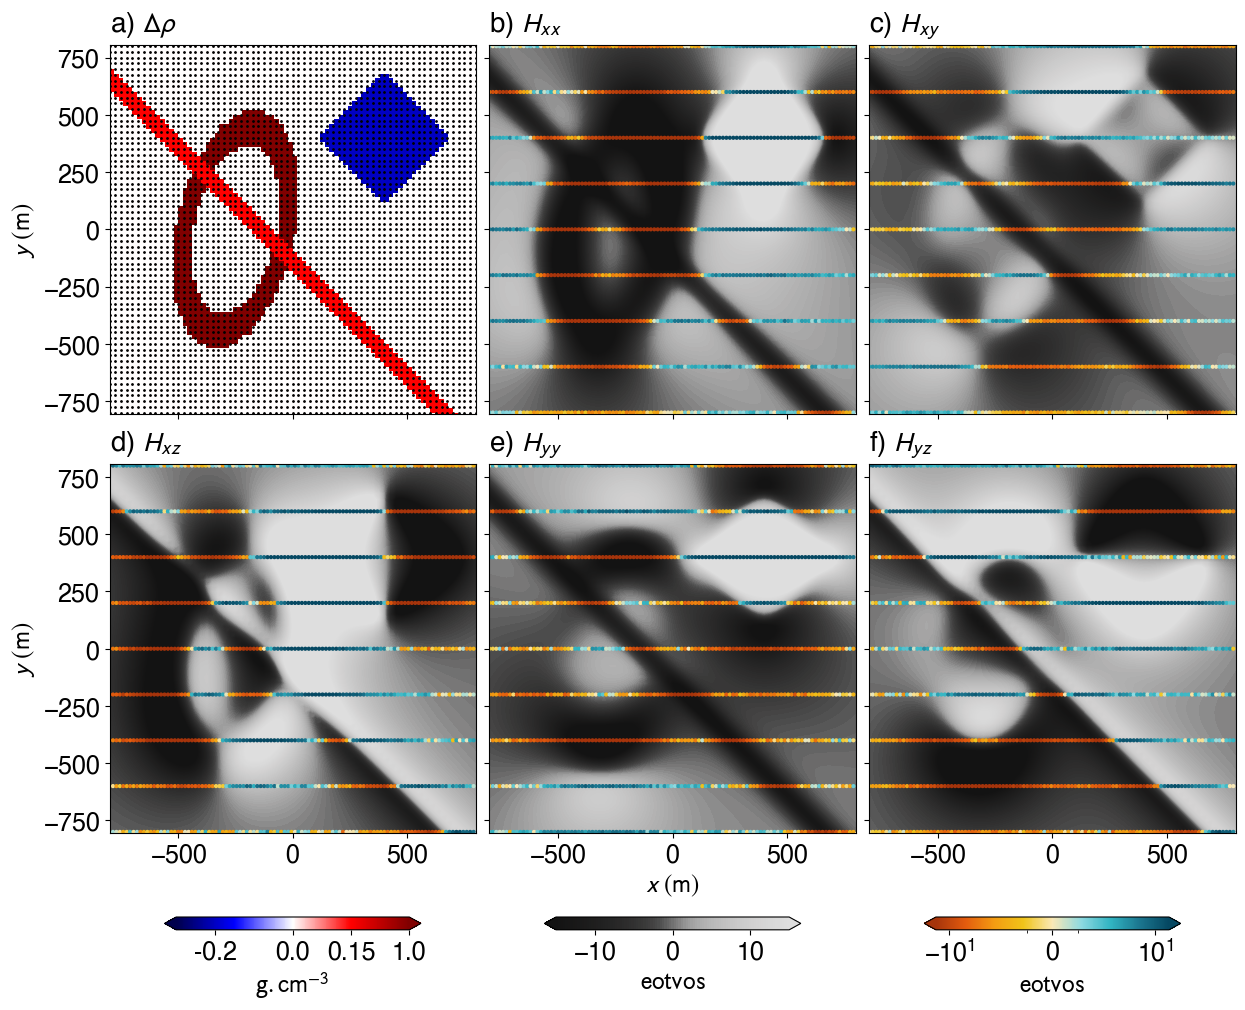

In [5]:
# Plot the data
fig, ax = plt.subplots(2, 3, figsize=(13, 10), sharex=True, sharey=True, layout="compressed")
a_ = ax.ravel()
# Set the labels and titles
labels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) "]
titles = [r"$\Delta \rho$", r"$H_{xx}$", r"$H_{xy}$",
          r"$H_{xz}$", r"$H_{yy}$", r"$H_{yz}$"]
cmap = cmr.get_sub_cmap('cmr.neutral', 0.1, 0.9)

# High resolution grid with contourf()
_ = [a_[i].contourf(x_mesh, y_mesh, ftg_hr[:, i-1].reshape(shape).T, np.linspace(-15, 15, 100), norm=mcolors.SymLogNorm(1, 0.3), extend="both", cmap=cmap) for i in range(1, 6)]
m = _[-1]
m_model = a_[0].pcolormesh(model_x, model_y, plot_model[:, -1].reshape((120, 120)), vmin=-0.3, vmax=0.3, cmap="seismic")

# Make the colorbars
plt.colorbar(mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(-0.3, 0.3), cmap="seismic"), ax=a_[3], orientation="horizontal",
             shrink=0.7, ticks=[-0.2, 0.0, 0.15, 0.3], label=r"$\mathrm{g.cm^{-3}}$", extend="both").set_ticklabels(["-0.2", "0.0", "0.15", "1.0"])

# Plot the high resolution grid
a_[0].scatter(xvec, yvec, s=1, c="k")

# Make the plot pretty :-)
_ = [a_[i].set_ylim([-805, 805]) for i in range(len(ax.ravel()))]
_ = [a_[i].set_xlim([-800, 800]) for i in range(len(ax.ravel()))]

# Low resolution data with scatter()
_ = [a_[i].scatter(xyz[:,0], xyz[:, 1], s=4, c=ftg[:, i-1], norm=mcolors.SymLogNorm(1, 0.3, -15, 15), cmap=curlew_cont) for i in range(1, 6)]
m_ = _[-1]
_ = [a_[i].set_title(labels[i] + titles[i], pad=10, loc="left") for i in range(len(titles))]
_ = [ax_.set_aspect('equal') for ax_ in a_]
plt.colorbar(mappable=m, ax=ax.ravel()[4], orientation="horizontal", ticks=[-10, 0, 10], label=r"$\mathrm{eotvos}$", shrink=0.7)
plt.colorbar(mappable=m_, ax=ax.ravel()[5], orientation="horizontal", ticks=[-10, 0, 10], label=r"$\mathrm{eotvos}$", shrink=0.7, extend="both")

# Set the labels
a_[0].set_ylabel(r"$y\ (\mathrm{m})$")
a_[3].set_ylabel(r"$y\ (\mathrm{m})$")
a_[4].set_xlabel(r"$x\ (\mathrm{m})$")

# Save the figure (optional)
plt.savefig("./Figures/synthetic_model_data.png", dpi=350)
plt.show()

### Prepare for training

We need to conver the locations and data into `torch.Tensor` to enable training!

In [6]:
# Prepare the data for training. We create a perturbation in the z direction to help the model converge faster.
xyz_perturb = np.copy(xyz)
xyz_perturb[:, 2] += (np.random.randn(xyz.shape[0]))
# Convert to torch Tensors
xyz_torch = torch.tensor(xyz_perturb, device=device, dtype=dtype)
ftg_torch = torch.tensor(ftg, device=device, dtype=dtype)  # xx, xy, xz, yy, yz, zz

# Preload active grid points (for Laplacian loss)
actv_points = np.c_[xvec, yvec, zvec][actv]  # shape: (N_active, 3)
actv_points_torch = torch.tensor(actv_points, device=device, dtype=dtype)

### Load `RFFEnsemble`

Load and initialise a `RFFEnsemble` object with the desired length scales, Fourier features and activation functions.

In [28]:
# Initialise
ens = tw.RFFEnsemble(n_members=25, model_kwargs=dict(num_fourier_features=16, length_scales=[2e2, 4e2, 1e3], learnable=True, potential_scale=5e6,
                                                      device=device, hidden_layers=[256, 256], activation=nn.SiLU()))

In [29]:
ens.fit(coords=xyz_torch,
        data=ftg_torch,
        grid=actv_points_torch,
        epochs=400,
        lr=1e-2,
        lap_spacing=(250, 80, 6, 1, 30),
        lap_samples=1000, chunk_size=1024
       )

Model #0


Training: 100%|██████████| 400/400 [00:45<00:00,  8.72it/s, loss=6.6260, ftg=[0.788, 0.629, 1.183, 1.214, 1.201, 1.381], lap=0.230, lr=0.000859, lap_ns=262, stall=0]    


Model #1


Training: 100%|██████████| 400/400 [00:51<00:00,  7.79it/s, loss=6.4407, ftg=[0.839, 0.659, 1.157, 1.160, 1.082, 1.274], lap=0.269, lr=0.00107, lap_ns=258, stall=0]       


Model #2


Training: 100%|██████████| 400/400 [00:51<00:00,  7.77it/s, loss=6.5546, ftg=[0.808, 0.594, 1.193, 1.212, 1.077, 1.390], lap=0.280, lr=0.00107, lap_ns=256, stall=18]         


Model #3


Training: 100%|██████████| 400/400 [00:50<00:00,  7.97it/s, loss=6.6717, ftg=[0.829, 0.674, 1.151, 1.273, 1.220, 1.342], lap=0.183, lr=0.00044, lap_ns=260, stall=11]        


Model #4


Training: 100%|██████████| 400/400 [00:49<00:00,  8.06it/s, loss=6.6255, ftg=[0.820, 0.628, 1.246, 1.142, 1.170, 1.320], lap=0.298, lr=0.00168, lap_ns=261, stall=0]       


Model #5


Training: 100%|██████████| 400/400 [00:50<00:00,  7.96it/s, loss=6.3766, ftg=[0.812, 0.554, 1.218, 1.153, 1.103, 1.257], lap=0.279, lr=0.000859, lap_ns=260, stall=16]        


Model #6


Training: 100%|██████████| 400/400 [00:50<00:00,  7.89it/s, loss=6.5939, ftg=[0.820, 0.626, 1.288, 1.236, 1.114, 1.349], lap=0.162, lr=0.00055, lap_ns=265, stall=0]          


Model #7


Training: 100%|██████████| 400/400 [00:51<00:00,  7.83it/s, loss=6.3192, ftg=[0.765, 0.612, 1.183, 1.169, 1.160, 1.251], lap=0.180, lr=0.00044, lap_ns=271, stall=32]        


Model #8


Training: 100%|██████████| 400/400 [00:48<00:00,  8.20it/s, loss=7.1117, ftg=[0.868, 0.702, 1.174, 1.239, 1.232, 1.483], lap=0.415, lr=0.00107, lap_ns=258, stall=0]     


Model #9


Training: 100%|██████████| 400/400 [00:46<00:00,  8.51it/s, loss=6.4413, ftg=[0.784, 0.646, 1.129, 1.179, 1.207, 1.279], lap=0.217, lr=0.00134, lap_ns=254, stall=0]          


Model #10


Training: 100%|██████████| 400/400 [00:49<00:00,  8.02it/s, loss=6.8541, ftg=[0.792, 0.663, 1.267, 1.222, 1.232, 1.370], lap=0.308, lr=0.00134, lap_ns=259, stall=5]     


Model #11


Training: 100%|██████████| 400/400 [00:56<00:00,  7.08it/s, loss=6.5461, ftg=[0.815, 0.644, 1.177, 1.197, 1.137, 1.378], lap=0.198, lr=0.00044, lap_ns=253, stall=9]        


Model #12


Training: 100%|██████████| 400/400 [01:21<00:00,  4.92it/s, loss=6.4549, ftg=[0.838, 0.572, 1.209, 1.160, 1.038, 1.326], lap=0.312, lr=0.00168, lap_ns=266, stall=0]    


Model #13


Training: 100%|██████████| 400/400 [01:05<00:00,  6.07it/s, loss=6.6571, ftg=[0.848, 0.609, 1.232, 1.184, 1.169, 1.386], lap=0.228, lr=0.00107, lap_ns=259, stall=0]          


Model #14


Training: 100%|██████████| 400/400 [01:08<00:00,  5.82it/s, loss=6.5763, ftg=[0.824, 0.642, 1.211, 1.138, 1.080, 1.382], lap=0.301, lr=0.00107, lap_ns=257, stall=0]      


Model #15


Training: 100%|██████████| 400/400 [01:02<00:00,  6.40it/s, loss=6.5540, ftg=[0.757, 0.616, 1.211, 1.160, 1.241, 1.313], lap=0.257, lr=0.000859, lap_ns=259, stall=0]     


Model #16


Training: 100%|██████████| 400/400 [00:58<00:00,  6.89it/s, loss=6.7538, ftg=[0.785, 0.699, 1.220, 1.193, 1.240, 1.358], lap=0.259, lr=0.00107, lap_ns=254, stall=10]       


Model #17


Training: 100%|██████████| 400/400 [00:57<00:00,  6.97it/s, loss=6.9443, ftg=[0.787, 0.722, 1.243, 1.222, 1.218, 1.396], lap=0.357, lr=0.00134, lap_ns=253, stall=5]      


Model #18


Training: 100%|██████████| 400/400 [01:06<00:00,  6.05it/s, loss=6.7625, ftg=[0.830, 0.630, 1.229, 1.175, 1.081, 1.443], lap=0.375, lr=0.00168, lap_ns=261, stall=0]        


Model #19


Training: 100%|██████████| 400/400 [01:06<00:00,  6.04it/s, loss=6.5932, ftg=[0.807, 0.598, 1.232, 1.218, 1.107, 1.378], lap=0.254, lr=0.00107, lap_ns=265, stall=0]       


Model #20


Training: 100%|██████████| 400/400 [01:06<00:00,  5.99it/s, loss=6.4288, ftg=[0.800, 0.639, 1.157, 1.214, 1.086, 1.329], lap=0.204, lr=0.000687, lap_ns=268, stall=17]     


Model #21


Training: 100%|██████████| 400/400 [01:07<00:00,  5.89it/s, loss=6.7069, ftg=[0.770, 0.719, 1.238, 1.242, 1.220, 1.346], lap=0.171, lr=0.000687, lap_ns=260, stall=5]      


Model #22


Training: 100%|██████████| 400/400 [01:08<00:00,  5.87it/s, loss=6.7241, ftg=[0.808, 0.646, 1.202, 1.231, 1.113, 1.428], lap=0.296, lr=0.000859, lap_ns=262, stall=0]     


Model #23


Training: 100%|██████████| 400/400 [01:08<00:00,  5.85it/s, loss=6.3348, ftg=[0.806, 0.609, 1.124, 1.128, 1.122, 1.329], lap=0.216, lr=0.00044, lap_ns=261, stall=8]          


Model #24


Training: 100%|██████████| 400/400 [01:08<00:00,  5.84it/s, loss=7.3195, ftg=[0.752, 0.924, 1.243, 1.336, 1.347, 1.466], lap=0.251, lr=0.000859, lap_ns=260, stall=0]         


In [30]:
# Pickle the file and store!
_ = torch.save(ens, "../Models/synthetic_ensemble.pkl")

In [31]:
# Predict (NumPy in → NumPy out) + uncertainty
H_mean, H_std, (H_q05, H_q95) = ens.predict(coords=actv_points,
                                            output="hessian",
                                            return_std=True,
                                            return_quantiles=(0.05, 0.95)
                                           )

# Fill the grid
enf_grid = np.full((xvec.shape[0], 6), np.nan)
enf_std = np.full((xvec.shape[0], 6), np.nan)
enf_grid[actv] = H_mean.reshape(-1, 9)[:, (0, 1, 2, 4, 5, -1)]
enf_std[actv] = H_std.reshape(-1, 9)[:, (0, 1, 2, 4, 5, -1)]

### Other techniques

For comparison, we use the Radial Basis Function (RBF) Interpolator and the Clough Tocher Minimum Curvature (CT) Interpolator.

In [32]:
# Compute the RBF and CT
from scipy.interpolate import RBFInterpolator as RBF
from scipy.interpolate import CloughTocher2DInterpolator as CT

# Initialise the RBF
rbf_func = RBF(xyz[:, :-1], ftg, neighbors=250, smoothing=1e2)
rbf_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
rbf_grid[actv] = rbf_func(grid[actv, :-1])

# Initialise the CT
ct_func = CT(xyz[:, :-1], ftg)
ct_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
ct_grid[actv] = ct_func(grid[actv, :-1])

In [48]:
# Plotting indices and parameters
# Select indices corresponding to H_xx, H_xy, H_xz for display (adjust if needed)
idx = [0, 1, 2]
# Labels for NF, RBF and CT
sigma_labels = [r"$\sigma_{H_{xx}}$", r"$\sigma_{H_{xy}}$", r"$\sigma_{H_{xz}}$",
             r"$\sigma_{H_{yy}}$", r"$\sigma_{H_{yz}}$", r"$\sigma_{H_{zz}}$"]
enf_labels = [r"$H^{\mathrm{ENF}}_{xx}$", r"$H^{\mathrm{ENF}}_{xy}$", r"$H^{\mathrm{ENF}}_{xz}$",
              r"$H^{\mathrm{ENF}}_{yy}$", r"$H^{\mathrm{ENF}}_{yz}$", r"$H^{\mathrm{ENF}}_{zz}$"]
rbf_labels = [r"$H^{\mathrm{RBF}}_{xx}$", r"$H^{\mathrm{RBF}}_{xy}$", r"$H^{\mathrm{RBF}}_{xz}$",
              r"$H^{\mathrm{RBF}}_{yy}$", r"$H^{\mathrm{RBF}}_{yz}$", r"$H^{\mathrm{RBF}}_{zz}$"]
ct_labels = [r"$H^{\mathrm{CT}}_{xx}$", r"$H^{\mathrm{CT}}_{xy}$", r"$H^{\mathrm{CT}}_{xz}$",
             r"$H^{\mathrm{CT}}_{yy}$", r"$H^{\mathrm{CT}}_{yz}$", r"$H^{\mathrm{CT}}_{zz}$"]
# Colormap capping
cmax = 15

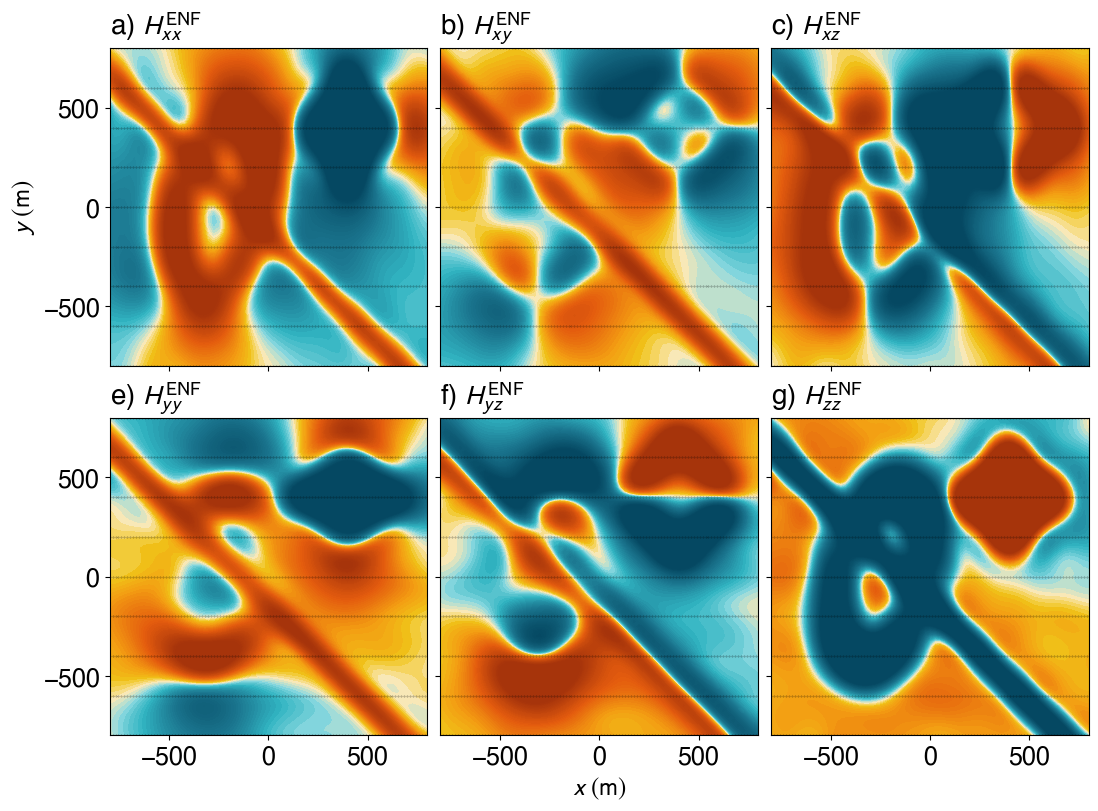

In [49]:
# Plot the NF!
fig, ax = plt.subplots(2, 3, figsize=(12, 8), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "e) ", "f) ", "g) "]

# Contour plots
for i in range(6):
    ax[i].contourf(
        x_mesh, y_mesh, enf_grid[:, i].reshape(shape).T,
        levels=np.linspace(-cmax, cmax, 100),
        norm=mcolors.SymLogNorm(1, 0.3),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(plot_labels[i] + enf_labels[i], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[4].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax]

plt.show()

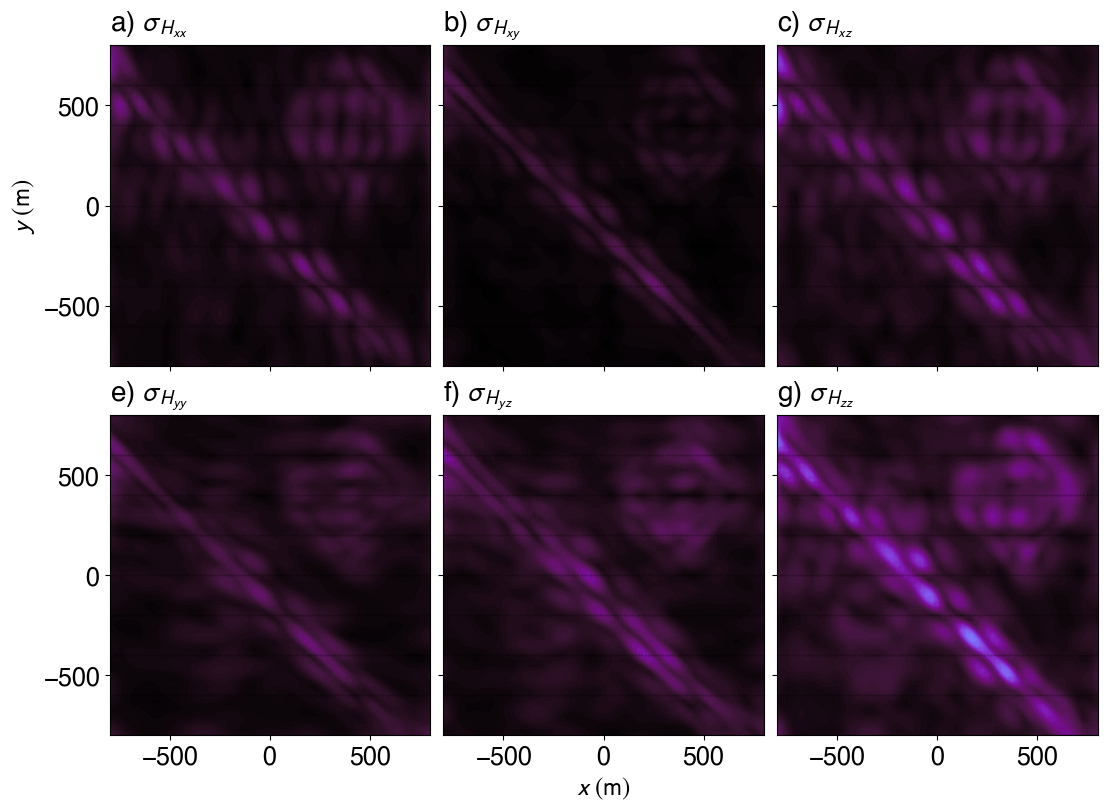

In [50]:
# Plot the NF!
fig, ax = plt.subplots(2, 3, figsize=(12, 8), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "e) ", "f) ", "g) "]

# Contour plots
for i in range(6):
    ax[i].contourf(
        x_mesh, y_mesh, enf_std[:, i].reshape(shape).T,
        levels=np.linspace(0, 5, 100),
        extend="both", cmap=cmr.voltage
    )
    ax[i].set_title(plot_labels[i] + sigma_labels[i], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[4].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax]

plt.show()

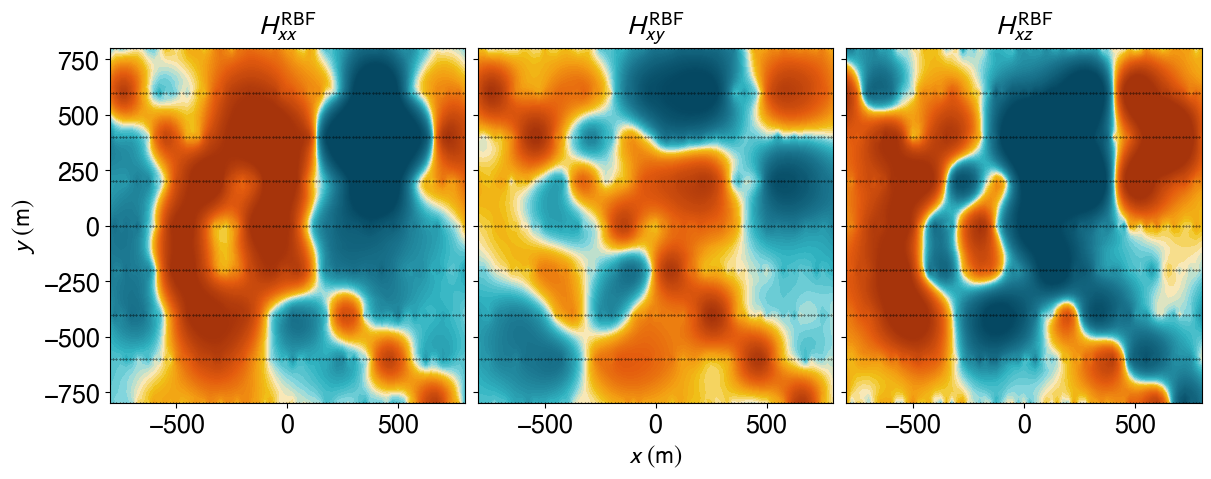

In [51]:
# Plot the RBF!
fig, ax = plt.subplots(1, 3, figsize=(12, 6), layout="compressed", sharex=True, sharey=True)

# Contour plots
for i in range(3):
    ax[i].contourf(
        x_mesh, y_mesh, rbf_grid[:, idx[i]].reshape(shape).T,
        levels=np.linspace(-cmax, cmax, 100),
        norm=mcolors.SymLogNorm(1, 0.3),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(rbf_labels[idx[i]], pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[1].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k') for a_ in ax]

plt.show()

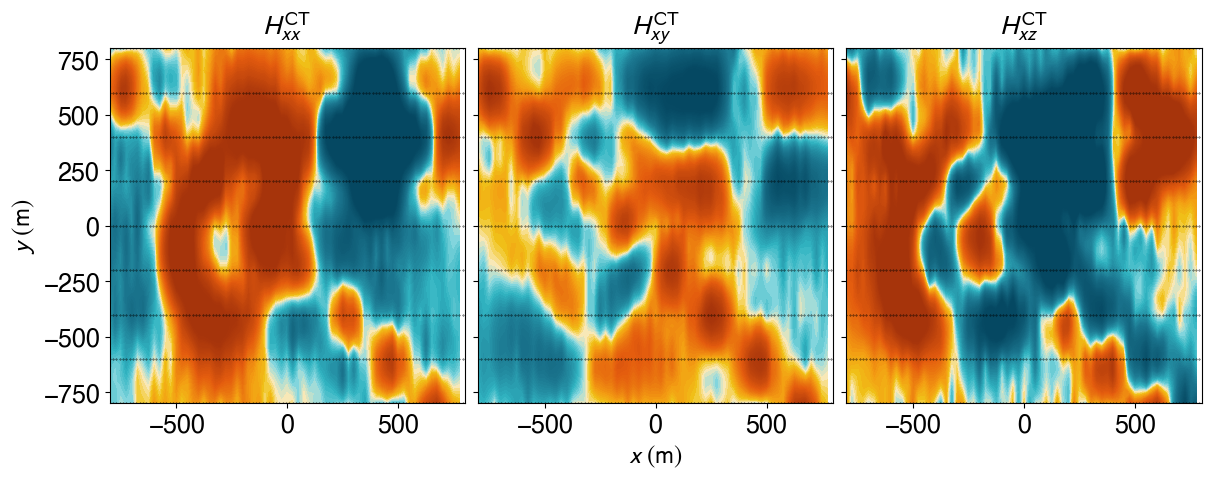

In [52]:
# Plot the CT!
fig, ax = plt.subplots(1, 3, figsize=(12, 6), layout="compressed", sharex=True, sharey=True)

# Contour plots
for i in range(3):
    ax[i].contourf(
        x_mesh, y_mesh, ct_grid[:, idx[i]].reshape(shape).T,
        levels=np.linspace(-cmax, cmax, 100),
        norm=mcolors.SymLogNorm(1, 0.3),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(ct_labels[idx[i]], pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[1].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k') for a_ in ax]

plt.show()

### Compare accuracy metrics across components!

In [53]:
# Accuracy metrics
from sklearn.metrics import r2_score, mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Clough-Tocher Minimum Curvature
ct_r2 = np.array([r2_score(ftg_hr[:, k].reshape(shape).T[:, :-1].ravel(), ct_grid[:, k].reshape(shape).T[:, :-1].ravel()) for k in range(5)])
norm_ct_r2 = np.linalg.norm(ct_r2)/ np.sqrt(5)  # Normalized R2 score
ct_ss = np.array([ssim(ftg_hr[:, k].reshape(shape).T[:, :-1], ct_grid[:, k].reshape(shape).T[:, :-1], data_range=1) for k in range(5)])
norm_ct_ss = np.linalg.norm(ct_ss)/ np.sqrt(5)  # Normalized SSIM
ct_mse = np.array([mean_squared_error(ftg_hr[:, k].reshape(shape).T[:, :-1].ravel(), ct_grid[:, k].reshape(shape).T[:, :-1].ravel()) for k in range(5)])
norm_ct_mse = np.linalg.norm(ct_mse)/ np.sqrt(5)  # Normalized MSE

# RBF
rbf_r2 = np.array([r2_score(ftg_hr[:, k], rbf_grid[:, k]) for k in range(5)])
norm_rbf_r2 = np.linalg.norm(rbf_r2)/ np.sqrt(5)  # Normalized R2 score
rbf_ss = np.array([ssim(ftg_hr[:, k].reshape(shape).T, rbf_grid[:, k].reshape(shape).T, data_range=1) for k in range(5)])
norm_rbf_ss = np.linalg.norm(rbf_ss)/ np.sqrt(5)  # Normalized SSIM
rbf_mse = np.array([mean_squared_error(ftg_hr[:, k], rbf_grid[:, k]) for k in range(5)])
norm_rbf_mse = np.linalg.norm(rbf_mse)/ np.sqrt(5)  # Normalized MSE

# Tensorweave
nf_r2 = np.array([r2_score(ftg_hr[:, k], enf_grid[:, k]) for k in range(5)])
norm_nf_r2 = np.linalg.norm(nf_r2)/ np.sqrt(5)  # Normalized R2 score
nf_ss = np.array([ssim(ftg_hr[:, k].reshape(shape).T, enf_grid[:, k].reshape(shape).T, data_range=1) for k in range(5)])
norm_nf_ss = np.linalg.norm(nf_ss)/ np.sqrt(5)  # Normalized SSIM
nf_mse = np.array([mean_squared_error(ftg_hr[:, k], enf_grid[:, k]) for k in range(5)])
norm_nf_mse = np.linalg.norm(nf_mse)/ np.sqrt(5)  # Normalized MSE


In [54]:
# Compare w.r.t RBF
ct_diff_r2 = 100*(norm_ct_r2 - norm_rbf_r2)/norm_rbf_r2
ct_diff_ss = 100*(norm_ct_ss - norm_rbf_ss)/norm_rbf_ss
ct_diff_mse = 100*(norm_ct_mse - norm_rbf_mse)/norm_rbf_mse
nf_diff_r2 = 100*(norm_nf_r2 - norm_rbf_r2)/norm_rbf_r2
nf_diff_ss = 100*(norm_nf_ss - norm_rbf_ss)/norm_rbf_ss
nf_diff_mse = 100*(norm_nf_mse - norm_rbf_mse)/norm_rbf_mse

In [55]:
# Display the normalized metrics
print(f"Clough Tocher Minimum Curvature:\n R\u00b2 = {norm_ct_r2:.3f} ({ct_diff_r2:.2f}%), SSIM = {norm_ct_ss:.3f}, "\
       f"({ct_diff_ss:.2f}%), MSE = {norm_ct_mse:.3f} ({ct_diff_mse:.2f}%)")
print(f"Radial Basis Functions:\n R\u00b2 = {norm_rbf_r2:.3f}, SSIM = {norm_rbf_ss:.3f}, MSE = {norm_rbf_mse:.3f}")
print(f"Tensorweave:\n R\u00b2 = {norm_nf_r2:.3f} ({nf_diff_r2:.2f}%), SSIM = {norm_nf_ss:.3f} ({nf_diff_ss:.2f}%), "\
       f"MSE = {norm_nf_mse:.3f} ({nf_diff_mse:.2f}%)")

Clough Tocher Minimum Curvature:
 R² = 0.878 (-3.98%), SSIM = 0.605, (-12.68%), MSE = 11.229 (41.93%)
Radial Basis Functions:
 R² = 0.915, SSIM = 0.693, MSE = 7.911
Tensorweave:
 R² = 0.993 (8.59%), SSIM = 0.949 (36.89%), MSE = 0.662 (-91.63%)
